In [9]:
!pip install xgboost

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LassoCV, RidgeCV
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
import joblib
import warnings

# Suppress warnings
warnings.filterwarnings("ignore", category=UserWarning)

# Load Dataset
df = pd.read_csv(r"C:\Users\DELL\Downloads\TASK-ML-INTERN.csv")

# Data Preprocessing
df.drop(columns=['hsi_id'], inplace=True)  # Remove ID column
X = df.drop(columns=['vomitoxin_ppb'])  # Features
y = df['vomitoxin_ppb']  # Target

# Handle missing values
X.ffill(inplace=True)

# Convert data types for efficiency
X = X.astype(np.float32)
y = y.astype(np.float32)

# Normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Standardize target variable
y_scaler = StandardScaler()
y_scaled = y_scaler.fit_transform(y.values.reshape(-1, 1)).flatten()

# Feature Selection using Lasso Regression
lasso = LassoCV(alphas=np.logspace(-3, -1, 20), cv=3, max_iter=50000).fit(X_scaled, y_scaled)
selected_features = np.where(lasso.coef_ != 0)[0]
X_selected = X_scaled[:, selected_features] if selected_features.size > 0 else X_scaled

# Alternative Feature Selection using Ridge Regression (if Lasso fails)
if selected_features.size == 0:
    ridge = RidgeCV(alphas=np.logspace(-3, -1, 20), store_cv_values=True).fit(X_scaled, y_scaled)
    selected_features = np.argsort(np.abs(ridge.coef_))[-min(10, X_scaled.shape[1]):]  # Top 10 features
    X_selected = X_scaled[:, selected_features]

# PCA for Dimensionality Reduction
n_components = min(5, X_selected.shape[1])
pca = PCA(n_components=n_components)
X_pca = pca.fit_transform(X_selected)
print("Explained Variance Ratio:", pca.explained_variance_ratio_)

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42)

# Hyperparameter Tuning for Random Forest
param_grid_rf = {
    'n_estimators': [100, 150],
    'max_depth': [None, 10],
    'min_samples_split': [2, 5]
}
rf = RandomForestRegressor(random_state=42)
grid_search_rf = GridSearchCV(rf, param_grid_rf, cv=3, scoring='r2', n_jobs=-1)
grid_search_rf.fit(X_train, y_train)
best_rf = grid_search_rf.best_estimator_

# Hyperparameter Tuning for XGBoost
param_grid_xgb = {
    'n_estimators': [100, 150],
    'learning_rate': [0.05, 0.1],
    'max_depth': [3, 5]
}
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
grid_search_xgb = GridSearchCV(xgb_model, param_grid_xgb, cv=3, scoring='r2', n_jobs=-1)
grid_search_xgb.fit(X_train, y_train)
best_xgb = grid_search_xgb.best_estimator_

# Predictions
y_pred_rf = best_rf.predict(X_test)
y_pred_xgb = best_xgb.predict(X_test)

# Weighted Ensemble
y_pred_ensemble = 0.5 * y_pred_rf + 0.5 * y_pred_xgb  # Equal weighting for stability

# Model Evaluation
def evaluate_model(y_true, y_pred, model_name):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    print(f"{model_name} - MAE: {mae:.4f}, RMSE: {rmse:.4f}, R^2: {r2:.4f}")

evaluate_model(y_test, y_pred_rf, "Random Forest")
evaluate_model(y_test, y_pred_xgb, "XGBoost")
evaluate_model(y_test, y_pred_ensemble, "Ensemble")

# Save Best Model
joblib.dump(best_rf, 'best_rf_model.pkl')
joblib.dump(best_xgb, 'best_xgb_model.pkl')
joblib.dump(scaler, 'scaler.pkl')
joblib.dump(pca, 'pca.pkl')
joblib.dump(y_scaler, 'y_scaler.pkl')


Explained Variance Ratio: [0.8622506  0.0689947  0.03450606 0.00370006 0.00280773]
Random Forest - MAE: 1688.6565, RMSE: 3185.6546, R^2: 0.9637
XGBoost - MAE: 1735.3701, RMSE: 3692.3079, R^2: 0.9512
Ensemble - MAE: 1591.2766, RMSE: 3142.3108, R^2: 0.9647


['y_scaler.pkl']

Explained Variance Ratio: [0.8622506  0.0689947  0.03450606 0.00370006 0.00280773]
Random Forest - MAE: 1688.6565, RMSE: 3185.6546, R^2: 0.9637
XGBoost - MAE: 1735.3701, RMSE: 3692.3079, R^2: 0.9512
Ensemble - MAE: 1591.2766, RMSE: 3142.3108, R^2: 0.9647


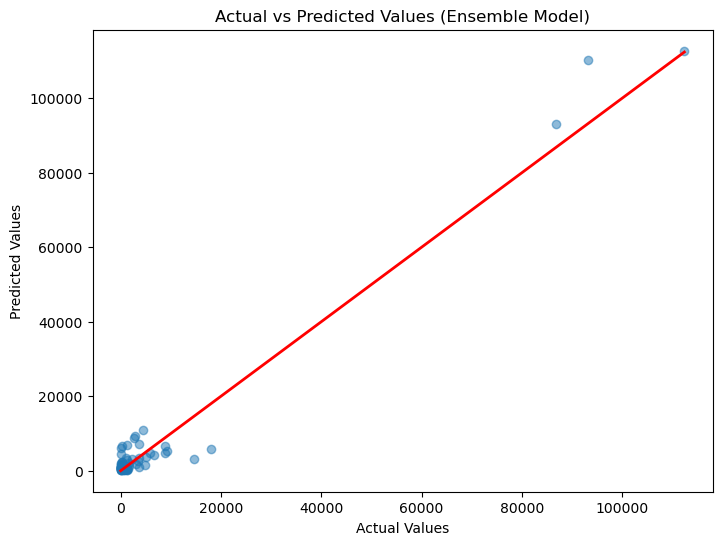

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.linear_model import LassoCV, RidgeCV
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
import joblib
import warnings

# Suppress warnings
warnings.filterwarnings("ignore", category=UserWarning)

# Load Dataset
df = pd.read_csv(r"C:\Users\DELL\Downloads\TASK-ML-INTERN.csv")

# Data Preprocessing
df.drop(columns=['hsi_id'], inplace=True)  # Remove ID column
X = df.drop(columns=['vomitoxin_ppb'])  # Features
y = df['vomitoxin_ppb']  # Target

# Handle missing values
X.ffill(inplace=True)

# Convert data types for efficiency
X = X.astype(np.float32)
y = y.astype(np.float32)

# Normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Standardize target variable
y_scaler = StandardScaler()
y_scaled = y_scaler.fit_transform(y.values.reshape(-1, 1)).flatten()

# Feature Selection using Lasso Regression
lasso = LassoCV(alphas=np.logspace(-3, -1, 20), cv=3, max_iter=50000).fit(X_scaled, y_scaled)
selected_features = np.where(lasso.coef_ != 0)[0]
X_selected = X_scaled[:, selected_features] if selected_features.size > 0 else X_scaled

# Alternative Feature Selection using Ridge Regression 
if selected_features.size == 0:
    ridge = RidgeCV(alphas=np.logspace(-3, -1, 20), store_cv_values=True).fit(X_scaled, y_scaled)
    selected_features = np.argsort(np.abs(ridge.coef_))[-min(10, X_scaled.shape[1]):]  # Top 10 features
    X_selected = X_scaled[:, selected_features]

# PCA for Dimensionality Reduction
n_components = min(5, X_selected.shape[1])
pca = PCA(n_components=n_components)
X_pca = pca.fit_transform(X_selected)
print("Explained Variance Ratio:", pca.explained_variance_ratio_)

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42)

# Hyperparameter Tuning for Random Forest
param_grid_rf = {
    'n_estimators': [100, 150],
    'max_depth': [None, 10],
    'min_samples_split': [2, 5]
}
rf = RandomForestRegressor(random_state=42)
grid_search_rf = GridSearchCV(rf, param_grid_rf, cv=3, scoring='r2', n_jobs=-1)
grid_search_rf.fit(X_train, y_train)
best_rf = grid_search_rf.best_estimator_

# Hyperparameter Tuning for XGBoost
param_grid_xgb = {
    'n_estimators': [100, 150],
    'learning_rate': [0.05, 0.1],
    'max_depth': [3, 5]
}
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
grid_search_xgb = GridSearchCV(xgb_model, param_grid_xgb, cv=3, scoring='r2', n_jobs=-1)
grid_search_xgb.fit(X_train, y_train)
best_xgb = grid_search_xgb.best_estimator_

# Predictions
y_pred_rf = best_rf.predict(X_test)
y_pred_xgb = best_xgb.predict(X_test)

# Weighted Ensemble
y_pred_ensemble = 0.5 * y_pred_rf + 0.5 * y_pred_xgb  # Equal weighting for stability

# Model Evaluation
def evaluate_model(y_true, y_pred, model_name):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    print(f"{model_name} - MAE: {mae:.4f}, RMSE: {rmse:.4f}, R^2: {r2:.4f}")

evaluate_model(y_test, y_pred_rf, "Random Forest")
evaluate_model(y_test, y_pred_xgb, "XGBoost")
evaluate_model(y_test, y_pred_ensemble, "Ensemble")

# Visualization - Scatter Plot
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_ensemble, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r', lw=2)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs Predicted Values (Ensemble Model)")
plt.show()

# Save Best Model
joblib.dump(best_rf, 'best_rf_model.pkl')
joblib.dump(best_xgb, 'best_xgb_model.pkl')
joblib.dump(scaler, 'scaler.pkl')
joblib.dump(pca, 'pca.pkl')
joblib.dump(y_scaler, 'y_scaler.pkl')